# Hypothesis Testing (Demo)

In this section, you will learn how to create hypotheses about edge formation, and how to test them using QAP and MRQAP.

---

In [1]:
# In this demo we will need an aditional package: fast-pagerank
# In case you don't have it installed, 
# you can install it directly from this notebook.
# Uncomment the following two lines:

#import sys
#!{sys.executable} -m pip install fast-pagerank

In [2]:
#### Dependencies
import networkx as nx
import pandas as pd
from scipy.sparse import csr_matrix

In [3]:
#### Local dependencies
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append('../libs/')

import compsoc as cs # library to load and plot our datasets
import helper        # library with functions to create hypotheses

---
## 1. Loading data
Florentine families graph: marriage and business ties among Renaissance Florentine families

In [4]:
families, parties, relations, domains = cs.elite_families_collection(path="../../data/elite_families/")

### Node metadata
- What are the nodes? 
- How are nodes identified? 
- How are nodes characterized?

In [5]:
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


### Edge metadata
- How are edges identified?
- How are edges characterized?
- How are layers identified?

In [6]:
relations.head()

,family_id_from,family_id_to,weight,domain_id
0,0,1,1,0
1,0,23,1,0
2,2,0,1,0
3,3,4,1,0
4,5,3,1,0


### Layer metadata
- What are the layers?

In [7]:
domains

,domain_id,domain
0,0,Marriage
1,1,Economic
2,2,Political
3,3,Friendship


---
## 2. Dyadic hypotheses
Let's look for correlations between layers (i.e. , tie domains)

### QAP - Quadratic Assignment Procedure
It performs a permutation test to calculate the significance of the correlation between two networks.\
\
*Hypothesis 2.1:\
Among elite families in Renaissance Florence, **business ties** are embedded in **marital relations**.* \
*i.e., families that are connected via marriage tend to do business together.*

#### Building hypotheses (adjacency matrices)

In [8]:
# IMPORTANT: Rows and columns in the adjacency matrix must have the same order of nodes!
# Thus, we take the order of nodes beforehand.
nodes = families.family_id

##### B: Business ties
Loading layer 'business' into adjacency matrix.\
Business (economy) ties represent domain_id = 1.

In [9]:
# alternative 1: select portions of data using column-series==value
tmp = relations[relations['domain_id']==1][['family_id_from','family_id_to','weight']] # keep the main columns s,t,w

B = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=False)
B.shape, B.min(), B.max(), B.sum()

((33, 33), 0, 1, 36)

In [10]:
# Let's check how the adjacency matrix looks like.
pd.DataFrame(B).head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### M: Marriage ties
Loading layer 'marriage' into adjacency matrix.\
Marriage ties represent domain_id = 0

In [11]:
# alternative 2: select portions of data using .query()
tmp = relations.query("domain_id == 0")[['family_id_from','family_id_to','weight']] # keep the main columns s,t,w

M = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=False)
M.shape, M.min(), M.max(), M.sum()

((33, 33), 0, 1, 58)

##### Running QAP

In [12]:
# We need to import the qap library
from qap import QAP

In [13]:
# Y: variable (matrix)
# X: variable (matrix)
qap_obj = QAP(Y=B, X=M, npermutations=50000, seed=12345)
qap_obj.qap()
qap_obj.summary()

[2020-09-24 20:12:53] Observed Pearson's correlation: 0.1838
[2020-09-24 20:13:11] 
[2020-09-24 20:13:11] # Permutations: 50000
[2020-09-24 20:13:11] Duration (sec.): 17
[2020-09-24 20:13:11] 
[2020-09-24 20:13:11] - Sum all betas: 6.517781000001342
[2020-09-24 20:13:11] - Min betas: -0.04529
[2020-09-24 20:13:11] - Max betas: 0.275382
[2020-09-24 20:13:11] - Average betas: 0.0001303556199999998
[2020-09-24 20:13:11] - Std. Dev. betas: 0.04394286907304249
[2020-09-24 20:13:11] 
[2020-09-24 20:13:11] prop >= 0.1838: 0.00194 P(Large)
[2020-09-24 20:13:11] prop <= 0.1838: 0.99806 P(Small)


**NUMERIC INTERPRETATION**\
We got a correlation of $\rho=0.1838$, which is positive, then the `Business` ties are positively correlated to the `Marriage` ties by 18%.\
However, with cannot conclude yet, whether this is completly true or not. We need to look at the significance test as well, to verify whether the correlation happened just by chance, or because of an actual dependency.\
In this case, (since $\rho=0.1838>0$) we use the `p-value` from $P(Large)$, and we can conclude that our $\text{p-value}=0.001$ is statiscally significant, and we can **reject the NULL hypothesis.**\
\
REMEMBER: Every time we use QAP or MRAP, our NULL hypothesis refers to the **NO** dependency (or correlation) between networks.

**GRAPHICAL INTERPRETATION**\
The function `.plot()`, plots the distribution of $\rho$ values computed on every shuffled (permuted) network.\
Then, blue bars represent this distribution: i.e., NULL hypothesis, and orange dotted vertical line represents the actual correlation between the two networks.\
In this example, we see that the orange line is very far from the blue bars. This means that we can reject the NULL hypothesis.

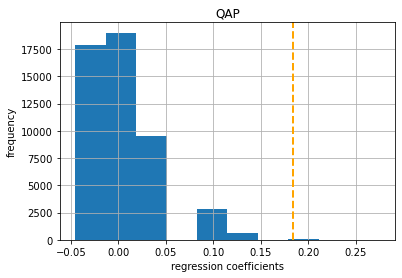

In [14]:
qap_obj.plot()

### MRQAP - Multiple (linear) regression QAP
It performs a permutation test to calculate the significance of the regression coefficients: `layer1 ~ layer2 + layer 3`\
\
*Hypothesis 2.2:\
**Economic ties** are embedded in **marriage**, **friendship**, and **political** ties.*

##### F: Friendship ties
Loading layer 'friendship' into adjacency matrix.\
friendship ties represent domain_id = 3

In [15]:
tmp = relations.query("domain_id == 3")[['family_id_from','family_id_to','weight']]
F = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=False)
F.shape, F.min(), F.max(), F.sum()

((33, 33), 0, 1, 14)

##### P: Political ties
Loading layer 'political' into adjacency matrix.\
political ties represent domain_id = 2

In [16]:
tmp = relations.query("domain_id == 2")[['family_id_from','family_id_to','weight']]
P = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=False)
P.shape, P.min(), P.max()

((33, 33), 0, 2)

##### Running MRQAP

In [17]:
from mrqap import MRQAP

In [18]:
# Y and X are dictionaries just to identify the variable names
# Y represents the dependent variable
# X all independent variables (in dyadic-level all are matrices)
Y = {'business':B}
X = {'marriage':M, 'friendship':F, 'political':P}
mrqap_obj = MRQAP(Y=Y, X=X, npermutations=10000, standarized=True, seed=12345)
mrqap_obj.mrqap()

In [19]:
mrqap_obj.summary(verbose=False)


                 business ~ marriage + friendship + political                 
   R-Square  Adj. R-Sqr.    Obs.  Perms.  Duration (sec.)
0    0.1046        0.102  1056.0   10000              210

                           Summary Permutation Test                           

               MIN     MAX  MEDIAN    MEAN     STD    BETA    P(+)    P(-)
Intercept       -0      -0       0       0       0       0       0       1
marriage   -0.1179  0.2421 -0.0008  0.0001   0.048  0.1518  0.0058  0.9942
friendship -0.1171  0.3509 -0.0176  0.0001  0.0471 -0.1453       1       0
political  -0.1129  0.2852  -0.016 -0.0005  0.0468   0.268  0.0001  0.9999


**NUMERIC INTERPRETATION**\
In the case of regression, we first need to look at each independent variable (variables we set into the dictionary `X`). In this case marriage, friendship, and political ties. Then we need to see at their $\beta$ coefficientes under the column `BETA`. Check whether they are positive or negative. If they are positive, the `p-value` that we need is `P(+)`, otherwise we use `P(-)`. Then, for each variable we ask whether the obtained coefficient is statistically significant or not. For example, `marriage` has a $\beta_{marriage}=0.1518$, and a $\text{p-value}=0.0058$, then we can conclude that (only for marriage) this beta coefficient is statisticaly significant, therefore, business ties depends on marriage ties. In the case of `friendship`, we see a negative $\beta_{friendship}=-0.1453$, then we use `P(-)` that is $\text{p-vlaue}=0$, which is statistically significant. This means that families do not make businesses with friends.\
\
After you look at the regression coefficients (beta values), you should also look at the `Adj. R-Square` value, which represents the adjusted goodness-of-fit of our model $business ~ marriage + friendship + political$, accounting for the number of variables. In this case $0.1046$.

**GRAPHICAL INTERPRETATION**\
Similar as in the graphical interpretation of QAP, but now we see the distributions of the regression coefficients for each independent variable X.\
Notice that we include the `Intercept` (often labeled as `constant`). It is the expected mean value of $Y$ when all $X=0$. Since we are using standarized variables `standarized=True`, the intercept is always $0$.

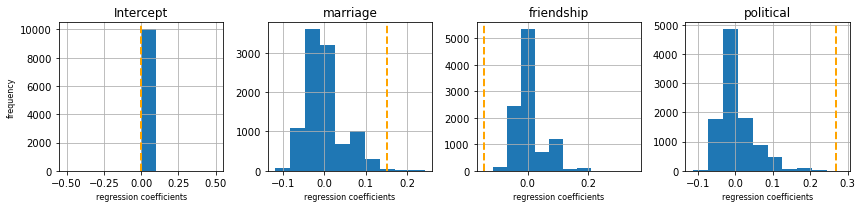

In [20]:
mrqap_obj.plot()

---
## 3. Mixed dyadic-monadic hypotheses
Now, let's look for correlations between layers and node attributes!

### MRQAP - Multiple (linear) regression quadratic assignment
It performs a permutation test to calculate the significance of the regression coefficients: `layer1 ~ layer2 + layer 3 + monadic`\
\
*Hypothesis 3.1:\
**Economic** ties are embedded in **marriage**, **friendship**, **political** ties, and same **party** membership, similar **gross wealth**, and same **status**.*

#### Building more hypotheses
In section 2 of this demo we created dyadic hypotheses.\
Now, let's create monadic hypothesis (i.e., based on homophily or popularity).\
*For example: Families that belong to the same party, are more likely to connect to each other.*

In [21]:
# let's recall the nodes' metadata
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


##### T: Same party members are more likely to make business together.
We need a function that compares the party membership of family_a (source) with the party membership of family_b (target).\
This comparison must return a high value (e.g., 1) when the parties of both families are the same, and a low value (e.g., 0) when they are different.\
Thus, we use the function `compare_same` from our `helper` library, which returns extacly that.\
REMEMBER: In a monadic or dyadic hypothesis matrix, `row_ids` refer to source nodes, and `column_ids` to target nodes.

In [22]:
# testing homophily on party membership
T = helper.get_monadic_hypothesis(families, 
                                  keyid='family_id', 
                                  attribute='party_id', 
                                  comparison_fnc=helper.compare_same, # 1 party_source == party_target, 0 otherwise
                                  symmetric=True, # sim(s,t) = sim(t,s) ?
                                  keyorder=nodes,
                                  dtype=int)

T.shape, T.min(), T.max(), T.sum()

((33, 33), 0, 1, 596)

In [23]:
# Let's check how the monadic matrix looks like.
pd.DataFrame(T).head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


##### G: Families with similar gross_wealth are more likely to make business together.
We need a high value when the gross_wealth of family_a is similar to the gross_wealth of family_b, and a low value otherwise.\
In other words, we need a high value when the difference of gross_wealth between the two families is low, and a low value when the difference is high.\
Thus, we calculate the inverse distance of the gross_wealth values between families.\
That is: `1/abs(gross_fam1 - gross_fam2)`.\
We use the function `compare_inverted_distance` from our `helper` library, which returns extacly that.\
If the difference (denominator) is small, then the two families are very likely to connect.


In [24]:
# testing homophily on gross_wealth
G = helper.get_monadic_hypothesis(families, 
                                  keyid='family_id', 
                                  attribute='gross_wealth_mean', 
                                  comparison_fnc=helper.compare_inverted_distance, 
                                  symmetric=True, # sim(s,t) = sim(t,s) ?
                                  keyorder=nodes)

G.shape, G.min(), G.max(), G.sum()

((33, 33), 0.0, 0.027777770061730538, 0.2796795343170124)

##### D: Similar status (date_of_first_prior)
Same as hypothesis **G (similar gross_weath)**. The difference relies only on the attribute.\
In this case we use `date_of_first_prior_mean` which refers to the status of the family.\
We use the function `compare_inverted_distance` from our `helper` library, which returns a value inversely proportional to the difference of statuses between families a and b.

In [25]:
D = helper.get_monadic_hypothesis(families, 
                                  keyid='family_id', 
                                  attribute='date_of_first_prior_mean', 
                                  comparison_fnc=helper.compare_inverted_distance, 
                                  symmetric=True, # sim(s,t) = sim(t,s) ?
                                  keyorder=nodes)

D.shape, D.min(), D.max(), D.sum()

((33, 33), 0.0, 99999.99999999999, 600091.9912177328)

##### Running MRQAP on mixed dyadic-monadic hypotheses

In [26]:
# Just to differentiate dyadic hypothesis from monadic hypothesis
# we refer to the former with UPPER case, and to the later with lower case.
Y = {'ECON':B}
X = {'MARR':M, 'FRIEND':F, 'POLIT':P, 'sa_party':T, 'sim_gross':G, 'sim_status':D}
mrqap_obj = MRQAP(Y=Y, X=X, npermutations=10000, standarized=True, seed=12345)
mrqap_obj.mrqap()

In [27]:
mrqap_obj.summary(verbose=False)


       ECON ~ MARR + FRIEND + POLIT + sa_party + sim_gross + sim_status       
   R-Square  Adj. R-Sqr.    Obs.  Perms.  Duration (sec.)
0    0.1108       0.1057  1056.0   10000              305

                           Summary Permutation Test                           

               MIN     MAX  MEDIAN    MEAN     STD    BETA    P(+)    P(-)
Intercept       -0      -0       0       0       0       0       0       1
MARR       -0.1136  0.2496 -0.0049  0.0002  0.0489  0.1387  0.0087  0.9913
FRIEND     -0.1149  0.3507 -0.0149  0.0001  0.0472 -0.1445       1       0
POLIT       -0.121  0.2956 -0.0141 -0.0005  0.0474  0.2756  0.0001  0.9999
sa_party   -0.1978  0.1423  -0.001 -0.0007  0.0462  0.0519  0.1195  0.8805
sim_gross  -0.0385  0.3151 -0.0141  0.0006  0.0443  0.0331  0.1025  0.8975
sim_status -0.0538  0.2807 -0.0121 -0.0002  0.0434 -0.0479  0.9994  0.0006


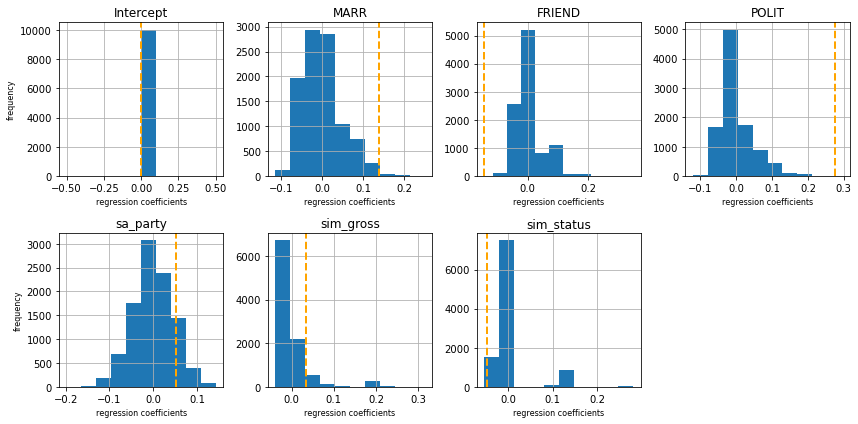

In [28]:
mrqap_obj.plot()

---
## 4. Node-Level Hypotheses (ego)
Finally, let's test hypothesis on the node-level (node-**structure** vs. node-**attribute**)\
**IMPORTANT:** Note that the variables for the node-level hypothesis are vectors!

### MRQAP
It performs a permutation test to calculate the significance of the regression coefficients: `node-property ~ node-attribute1 + node-attribute2`\
\
*Hypothesis 4.1:\
The larger the **economic degree** (more business ties), the higher the **gross wealth** and **status** of a family.*

In [29]:
# let's recall the nodes' metadata
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


##### Gr: Gross wealth (node attribute)

In [30]:
Gr = families.gross_wealth_mean.values

In [31]:
# Let's check how the 'node-attribute' vector looks like
Gr

array([ 82702,  42840,  40617,  21167,  13137,  18957,   8158,  19887,
        12420,  18921,  48364,  48066,  85300,  14529,   5403,  50125,
        37118,  14367,  19640,  13047, 135765,  31297,  64626,  49988,
        25874,  46875,   5757,  32388,  14054,  46308,  25179,  39365,
        19225])

##### S: Status (node attribute)
From the DataFrame containing all node information `families`, we only need 1 column; the column of interest.\
In this case `date_of_first_prior_mean`, referring to the `status` of a family.\
We can get that column with `families.date_of_first_prior_mean` or `families['date_of_first_prior_mean']`.\
If you try that, you will see that the column is a `pandas.Series`. However, the `MRQAP` library needs a vector as a `numpy.array`, so we access the array (from that column) with the attribute `.values`, as follows:

In [32]:
S = families.date_of_first_prior_mean.values

##### Ed: Economic degree (node structure)
The DataFrame containing all node information `families`, only contains node-attribute information.\
But we need structural properties. These properties are nowhere stored, we need to compute them from the adjacency matrix, which posses the structure of the whole network, and therefore it embeds the structure of each node.\
First, we are interested on the economic degree, then we need the economic (business) adjacency matrix.\
Second, we are interested on the degree of each node (i.e., the number of ties each family has in the economic network), then we use the function `ego_degree` from our `helper` library which takes the adjacency matrix, and returns a vector with the degree of every node.

In [33]:
Ed = helper.get_ego_hypothesis(adjacency=B,                 # business ties
                                ego_fnc=helper.ego_degree,  # function to compute ego-node property
                                missing=0)                  # how to deal with missing values (0, np.mean, etc.)

In [34]:
# Let's check how the 'node-structure' vector looks like
Ed

array([3, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 3, 1, 3, 3, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 2, 1, 3, 2, 0, 0, 0])

##### Running MRQAP on node-level hypotheses: ego_degree ~ wealth + status
Note that for node-level hypotheses, MRQAP requires the parameter `node_regression=True`.

In [35]:
Y = {'ego_degree':Ed}
X = {'wealth':Gr, 'status':S}
mrqap_obj = MRQAP(Y=Y, X=X, npermutations=10000, standarized=True, node_regression=True, seed=12345)
mrqap_obj.mrqap()

In [36]:
mrqap_obj.summary(verbose=False)


                         ego_degree ~ wealth + status                         
   R-Square  Adj. R-Sqr.  Obs.  Perms.  Duration (sec.)
0    0.1587       0.1007  32.0   10000              160

                           Summary Permutation Test                           

              MIN     MAX  MEDIAN    MEAN     STD    BETA    P(+)    P(-)
Intercept       0       0       0       0       0       0       0       1
wealth    -0.5342  0.6643 -0.0096  -0.001  0.1894 -0.1249  0.7244  0.2756
status    -0.6205  0.5902 -0.0003  0.0018   0.191  -0.428  0.9897  0.0103


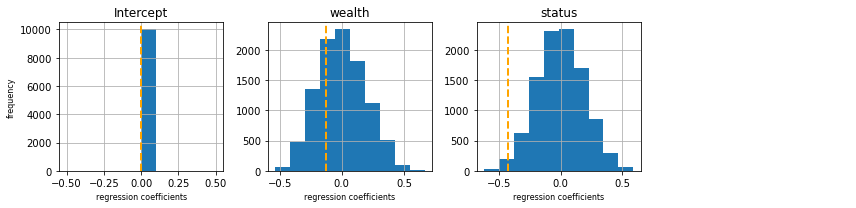

In [37]:
mrqap_obj.plot()

*Hypothesis 4.2:\
The larger the **economic density** of a node's neighborhood (more business ties among ego's connections),\
the higher the **gross wealth** and more **active oligarchs** in a family.*

In [38]:
# let's recall the nodes' metadata
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


##### Ao: Number of active oligarchs (node attribute)
Same as hypothesis **S (status)**,  we simply need to get the `numbers_active_oligarch` for each family.

In [39]:
Ao = families.numbers_active_oligarch.values

##### Ey: Economic density (node structure)
Similar to hypothesis **Ed (Economic degree)**, this is a node-structural hypothesis.\
Thus, we need to calculate a node property from the adjacency matrix.\
In thise case the density of the neighborhood of each node.\
We use the function `ego_density_directed` from our `helper` library.

In [40]:
Ey = helper.get_ego_hypothesis(adjacency=B,                          # business ties
                                ego_fnc=helper.ego_density_directed, # function to compute ego-node property
                                missing=0)                           # how to deal with missing values (0, np.mean, etc.)

##### Running MRQAP on node-level hypotheses: neighbors_density ~ wealth + status
**RECALL:** For node-level hypotheses, MRQAP requires the parameter `node_regression=True`.

In [41]:
Y = {'neig_density':Ey}
X = {'oligarch':Ao, 'status':S}
mrqap_obj = MRQAP(Y=Y, X=X, npermutations=10000, standarized=True, node_regression=True, seed=12345)
mrqap_obj.mrqap()

In [42]:
mrqap_obj.summary(verbose=False)


                       neig_density ~ oligarch + status                       
   R-Square  Adj. R-Sqr.  Obs.  Perms.  Duration (sec.)
0    0.3013       0.2531  32.0   10000              165

                           Summary Permutation Test                           

              MIN     MAX  MEDIAN    MEAN     STD    BETA    P(+)    P(-)
Intercept       0       0       0       0       0       0       1       1
oligarch  -0.5519  0.7008 -0.0091 -0.0019  0.1921  0.4762  0.0086  0.9914
status     -0.572  0.6841 -0.0017  0.0014  0.1927 -0.1499  0.7763  0.2237


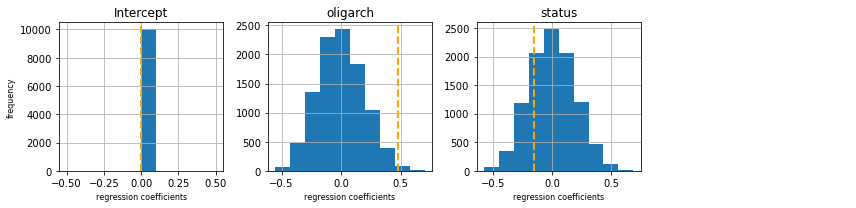

In [43]:
mrqap_obj.plot()